In [21]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    glucose_levels = []
    basal_insulin = []
    bolus_insulin = []
    carbs = []
    timestamps = []

    # Extract glucose levels
    for glucose_event in root.findall(".//glucose_level/event"):
        ts = glucose_event.get('ts')
        value = float(glucose_event.get('value'))
        glucose_levels.append((ts, value))

    # Extract basal insulin
    for basal_event in root.findall(".//basal/event"):
        ts = basal_event.get('ts')
        value = float(basal_event.get('value'))
        basal_insulin.append((ts, value))

    # Extract bolus insulin
    for bolus_event in root.findall(".//bolus/event"):
        ts = bolus_event.get('ts_begin')
        dose = float(bolus_event.get('dose'))
        bolus_insulin.append((ts, dose))

    # Extract meal data
    for meal_event in root.findall(".//meal/event"):
        ts = meal_event.get('ts')
        carbs_value = float(meal_event.get('carbs'))
        carbs.append((ts, carbs_value))

    # Combine all data into a DataFrame
    data = []
    for ts, glucose in glucose_levels:
        basal = next((value for t, value in basal_insulin if t == ts), 0)
        bolus = next((dose for t, dose in bolus_insulin if t == ts), 0)
        meal = next((carbs_value for t, carbs_value in carbs if t == ts), 0)
        data.append((ts, glucose, basal, bolus, meal))

    df = pd.DataFrame(data, columns=['timestamp', 'glucose', 'basal_insulin', 'bolus_insulin', 'carbs'])
    
    # Specify the correct format for parsing the timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M:%S')
    
    return df


In [3]:
def prepare_data(df):
    df = df.dropna()  # Drop rows with NaN values
    df.set_index('timestamp', inplace=True)

    # Scale features
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df[['basal_insulin', 'bolus_insulin', 'carbs']])
    scaled_glucose = scaler.fit_transform(df[['glucose']])

    return scaled_features, scaled_glucose



In [4]:
def train_lstm_model(X_train, y_train):
    # Reshape input to be [samples, time steps, features]
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for glucose prediction

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Fit the model
    model.fit(X_train_lstm, y_train, epochs=200, batch_size=32, verbose=0)

    return model


In [5]:
def evaluate_model(model, X_test, y_test):
    # Reshape test data for LSTM
    X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    predictions = model.predict(X_test_lstm)
    return predictions



In [15]:
if __name__ == "__main__":
    # Paths to training and testing XML files
    training_files = ['E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/540-ws-training.xml', 'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/544-ws-training.xml', 
                      'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/552-ws-training.xml', 'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/567-ws-training.xml', 
                      'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/584-ws-training.xml', 'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/596-ws-training.xml']

    testing_files = ['E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/540-ws-testing.xml', 'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/544-ws-testing.xml', 
                      'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/552-ws-testing.xml', 'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/567-ws-testing.xml', 
                      'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/584-ws-testing.xml', 'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/596-ws-testing.xml']

    # Initialize lists to hold training data
    all_train_data = []
    all_test_data = []

    for file in training_files:
        train_df = parse_xml(file)
        all_train_data.append(train_df)

    # Combine all training data into a single DataFrame
    train_data = pd.concat(all_train_data, ignore_index=True)
    for file in testing_files:
        test_df = parse_xml(file)
        all_test_data.append(test_df)

    # Combine all testing data into a single DataFrame
    test_data = pd.concat(all_test_data, ignore_index=True)
    X_train, y_train = prepare_data(train_data)

    # Prepare testing data
    X_test, y_test = prepare_data(test_data)

    lstm_model = train_lstm_model(X_train, y_train)

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
predictions = evaluate_model(lstm_model, X_test, y_test)

493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step


In [18]:
# Rescale predictions and actual values back to original scale
scaler = MinMaxScaler()
scaler.fit(train_data[['glucose']])  # Fit scaler on training glucose data
y_test_rescaled = scaler.inverse_transform(y_test)
predictions_rescaled = scaler.inverse_transform(predictions)

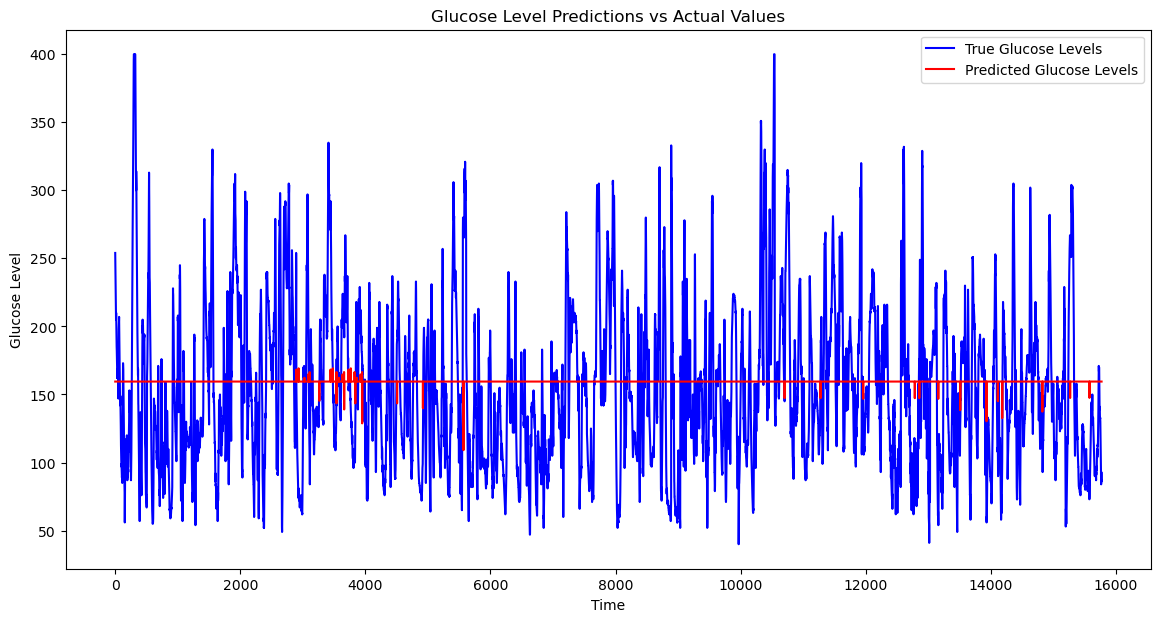

In [20]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test_rescaled, label='True Glucose Levels', color='blue')
plt.plot(test_data.index, predictions_rescaled, label='Predicted Glucose Levels', color='red')
plt.xlabel('Time')
plt.ylabel('Glucose Level')
plt.title('Glucose Level Predictions vs Actual Values')
plt.legend()
plt.show()

In [22]:
def calculate_accuracy(y_true, y_pred):
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

In [23]:
mae, mse, rmse = calculate_accuracy(y_test_rescaled, predictions_rescaled)

    # Print accuracy metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 46.65
Mean Squared Error (MSE): 3392.53
Root Mean Squared Error (RMSE): 58.25


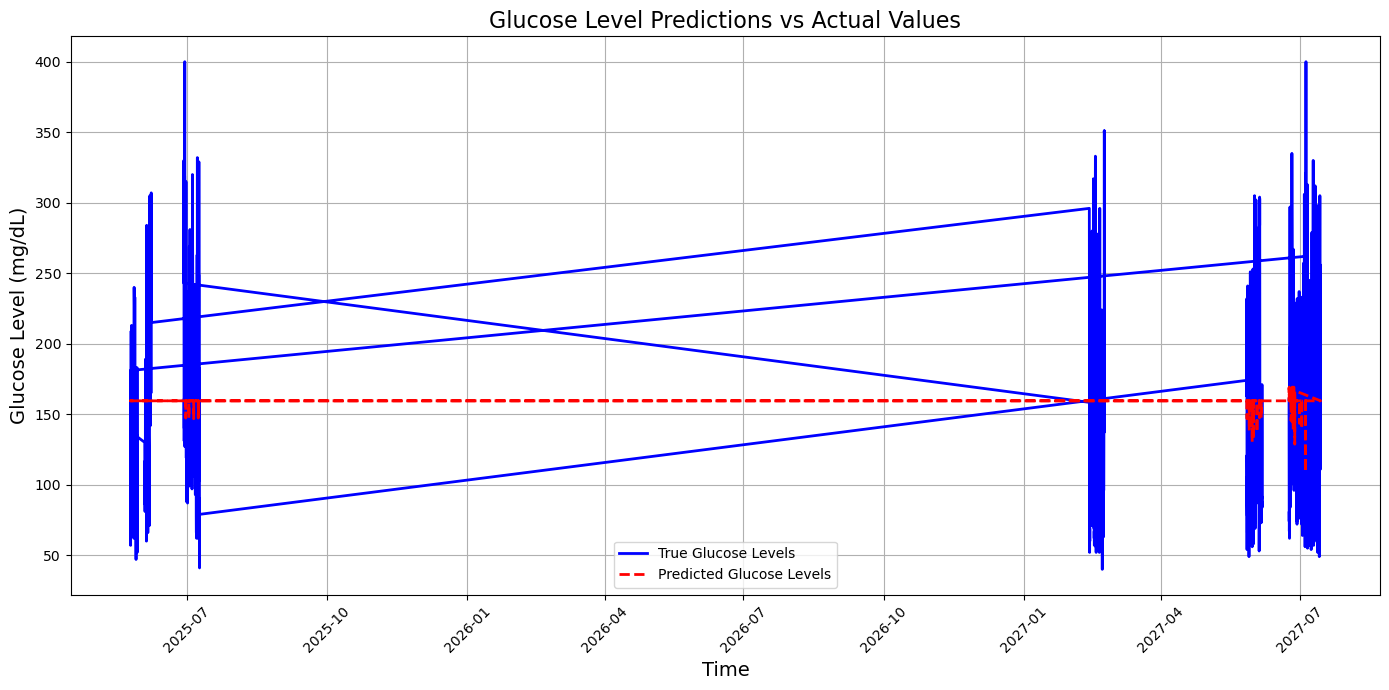

In [24]:
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])

# Create a new figure for the plot
plt.figure(figsize=(14, 7))

# Plot actual glucose levels
plt.plot(test_data['timestamp'], y_test_rescaled, label='True Glucose Levels', color='blue', linewidth=2)

# Plot predicted glucose levels
plt.plot(test_data['timestamp'], predictions_rescaled, label='Predicted Glucose Levels', color='red', linestyle='--', linewidth=2)

# Add titles and labels
plt.title('Glucose Level Predictions vs Actual Values', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Glucose Level (mg/dL)', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add a grid for easier visualization
plt.legend()  # Show legend
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()